In [1]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import spatial
import tqdm

from pymutspec.annotation import mutations_summary, calculate_mutspec, lbl_id2lbl, lbl2lbl_id
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.draw import plot_mutspec192, plot_mutspec12
from pymutspec.draw.sbs_orders import ordered_sbs192_kp

## Load data

### Load observed mutations

In [2]:
dtypes = dict(
    Label=np.int8, 
    # Mut="category",
    # RefCodon="category",
    # AltCodon="category",
    RefAa="category",
    AltAa="category",
    PosInGene=np.int16, 
    PosInCodon=np.int8, 
    ProbaRef=np.float32, 
    ProbaMut=np.float32, 
    ProbaFull=np.float32,
)

In [3]:
PATH_TO_DATA = "../data/exposure/mammals_nd1/"

mut_nd1 = pd.concat([
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/mutations.tsv"), dtype=dtypes, sep='\t').assign(Aproach="strsym_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/mutations.tsv"), dtype=dtypes, sep='\t').assign(Aproach="strsym_proba"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/mutations.tsv"), dtype=dtypes, sep='\t').assign(Aproach="unrest_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/mutations.tsv"), dtype=dtypes, sep='\t').assign(Aproach="unrest_proba"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "simple_v2/mutations.tsv"), dtype=dtypes, sep='\t').assign(Aproach="simple_v2"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "proba_v2/mutations.tsv"), dtype=dtypes, sep='\t').assign(Aproach="proba_v2"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml_v2/mutations.tsv"), dtype=dtypes, sep='\t').assign(Aproach="pastml_v2"),
], ignore_index=True).drop("Gene", axis=1).fillna(value=dict(ProbaMut=1., ProbaRef=1., ProbaFull=1.))

mut_nd1["MutBase"] = mut_nd1["Mut"].str.slice(2, 5).astype("category")

In [4]:
PATH_TO_DATA = "../data/exposure/mammals_cytb/"

mut_cytb = pd.concat([
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/mutations.tsv"), dtype=dtypes, sep='\t').assign(Aproach="strsym_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/mutations.tsv"), dtype=dtypes, sep='\t').assign(Aproach="strsym_proba"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/mutations.tsv"), dtype=dtypes, sep='\t').assign(Aproach="unrest_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/mutations.tsv"), dtype=dtypes, sep='\t').assign(Aproach="unrest_proba"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "simple_v2/mutations.tsv"), dtype=dtypes, sep='\t').assign(Aproach="simple_v2"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "proba_v2/mutations.tsv"), dtype=dtypes, sep='\t').assign(Aproach="proba_v2"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml_v2/mutations.tsv"), dtype=dtypes, sep='\t').assign(Aproach="pastml_v2"),
], ignore_index=True).drop("Gene", axis=1).fillna(value=dict(ProbaMut=1., ProbaRef=1., ProbaFull=1.))

mut_cytb["MutBase"] = mut_cytb["Mut"].str.slice(2, 5).astype("category")

In [5]:
mut_cytb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4757102 entries, 0 to 4757101
Data columns (total 15 columns):
 #   Column      Dtype   
---  ------      -----   
 0   Mut         object  
 1   Label       int8    
 2   PosInGene   int16   
 3   PosInCodon  int8    
 4   RefCodon    object  
 5   AltCodon    object  
 6   RefAa       category
 7   AltAa       category
 8   RefNode     object  
 9   AltNode     object  
 10  Aproach     object  
 11  ProbaRef    float32 
 12  ProbaMut    float32 
 13  ProbaFull   float32 
 14  MutBase     category
dtypes: category(3), float32(3), int16(1), int8(2), object(6)
memory usage: 304.0+ MB


In [34]:
mut_cytb.isna().sum(axis=0)

Mut           0
Label         0
PosInGene     0
PosInCodon    0
RefCodon      0
AltCodon      0
RefAa         0
AltAa         0
RefNode       0
AltNode       0
Aproach       0
ProbaRef      0
ProbaMut      0
ProbaFull     0
MutBase       0
dtype: int64

### Load expected mutations freqs

In [5]:
PATH_TO_DATA = "../data/exposure/mammals_cytb/"

dtypes_freqs = {x: np.float32 for x in possible_sbs12 + possible_sbs192}

freqs_cytb = pd.concat([
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/expected_mutations.tsv"), dtype=dtypes_freqs, sep='\t').assign(Aproach="strsym_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/expected_mutations.tsv"), dtype=dtypes_freqs, sep='\t').assign(Aproach="strsym_proba"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/expected_mutations.tsv"), dtype=dtypes_freqs, sep='\t').assign(Aproach="unrest_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/expected_mutations.tsv"), dtype=dtypes_freqs, sep='\t').assign(Aproach="unrest_proba"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "simple_v2/expected_mutations.tsv"), dtype=dtypes_freqs, sep='\t').assign(Aproach="simple_v2"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "proba_v2/expected_mutations.tsv"), dtype=dtypes_freqs, sep='\t').assign(Aproach="proba_v2"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml_v2/expected_mutations.tsv"), dtype=dtypes_freqs, sep='\t').assign(Aproach="pastml_v2"),
], ignore_index=True).drop("Gene", axis=1)


PATH_TO_DATA = "../data/exposure/mammals_nd1/"

freqs_nd1 = pd.concat([
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/expected_mutations.tsv"), dtype=dtypes_freqs, sep='\t').assign(Aproach="strsym_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/expected_mutations.tsv"), dtype=dtypes_freqs, sep='\t').assign(Aproach="strsym_proba"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/expected_mutations.tsv"), dtype=dtypes_freqs, sep='\t').assign(Aproach="unrest_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/expected_mutations.tsv"), dtype=dtypes_freqs, sep='\t').assign(Aproach="unrest_proba"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "simple_v2/expected_mutations.tsv"), dtype=dtypes_freqs, sep='\t').assign(Aproach="simple_v2"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "proba_v2/expected_mutations.tsv"), dtype=dtypes_freqs, sep='\t').assign(Aproach="proba_v2"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml_v2/expected_mutations.tsv"), dtype=dtypes_freqs, sep='\t').assign(Aproach="pastml_v2"),
], ignore_index=True).drop("Gene", axis=1)

In [41]:
freqs_nd1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37036 entries, 0 to 37035
Columns: 207 entries, Node to Aproach
dtypes: float16(204), object(3)
memory usage: 15.3+ MB


### How many mutations with diffrent types observed?

In [83]:
mutations_summary(mut_cytb, "Aproach", "ProbaFull").round(2)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Aproach,,,,,,
pastml_v2,11239.059570,145376.953125,68323.148438,48.990002,43.779999,0.07
proba_v2,9969.459961,128100.906250,68271.218750,28.770000,24.740000,0.01
simple_v2,10309.000000,82125.000000,41180.000000,4.000000,3.000000,0.00
strsym_proba,10442.299805,90004.367188,45554.558594,22.879999,21.010000,0.00
strsym_simple,10093.000000,80647.000000,40626.000000,2.000000,2.000000,0.00
unrest_proba,10136.679688,121434.023438,67188.656250,35.009998,27.219999,0.11
unrest_simple,9877.000000,90011.000000,50056.000000,8.000000,4.000000,1.00


In [84]:
mutations_summary(mut_nd1[mut_nd1.ProbaFull > 0.3], "Aproach", "ProbaFull").round(2)

,non-syn,syn,syn4f,Stop loss,Stop gain
Aproach,,,,,
pastml_v2,5088.359863,53128.320312,26792.369141,1.94,1.61
proba_v2,4862.250000,49671.839844,25296.679688,1.81,1.72
simple_v2,8358.000000,67575.000000,35267.000000,9.00,4.00
strsym_proba,6160.589844,55268.398438,28439.060547,0.63,1.71
strsym_simple,8126.000000,66202.000000,34582.000000,0.00,2.00
unrest_proba,5117.200195,55528.218750,30864.960938,1.80,1.68
unrest_simple,7915.000000,74350.000000,43210.000000,7.00,4.00


In [85]:
mutations_summary(mut_nd1, "Aproach", "ProbaFull").round(2)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Aproach,,,,,,
pastml_v2,9005.709961,118552.296875,58877.738281,10.69,5.44,0.03
proba_v2,8143.339844,107114.117188,59834.808594,8.91,4.54,0.06
simple_v2,8358.000000,67575.000000,35267.000000,9.00,4.00,0.00
strsym_proba,8388.169922,75946.468750,39267.390625,5.30,2.68,0.00
strsym_simple,8126.000000,66202.000000,34582.000000,0.00,2.00,0.00
unrest_proba,8185.279785,98511.000000,57126.558594,12.02,5.63,0.12
unrest_simple,7915.000000,74350.000000,43210.000000,7.00,4.00,0.00


In [86]:
mutations_summary(mut_cytb[mut_cytb.ProbaFull > 0.3], "Aproach", "ProbaFull").round(2)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Aproach,,,,,,
pastml_v2,6462.620117,65439.238281,31384.099609,1.71,1.97,0
proba_v2,6235.000000,59844.378906,28852.109375,2.13,1.82,0
simple_v2,10309.000000,82125.000000,41180.000000,4.00,3.00,0
strsym_proba,7819.839844,67289.570312,32939.218750,1.61,1.45,0
strsym_simple,10093.000000,80647.000000,40626.000000,2.00,2.00,0
unrest_proba,6482.930176,66599.101562,35168.878906,2.08,2.16,0
unrest_simple,9877.000000,90011.000000,50056.000000,8.00,4.00,1


**Probability distribution of mutations**

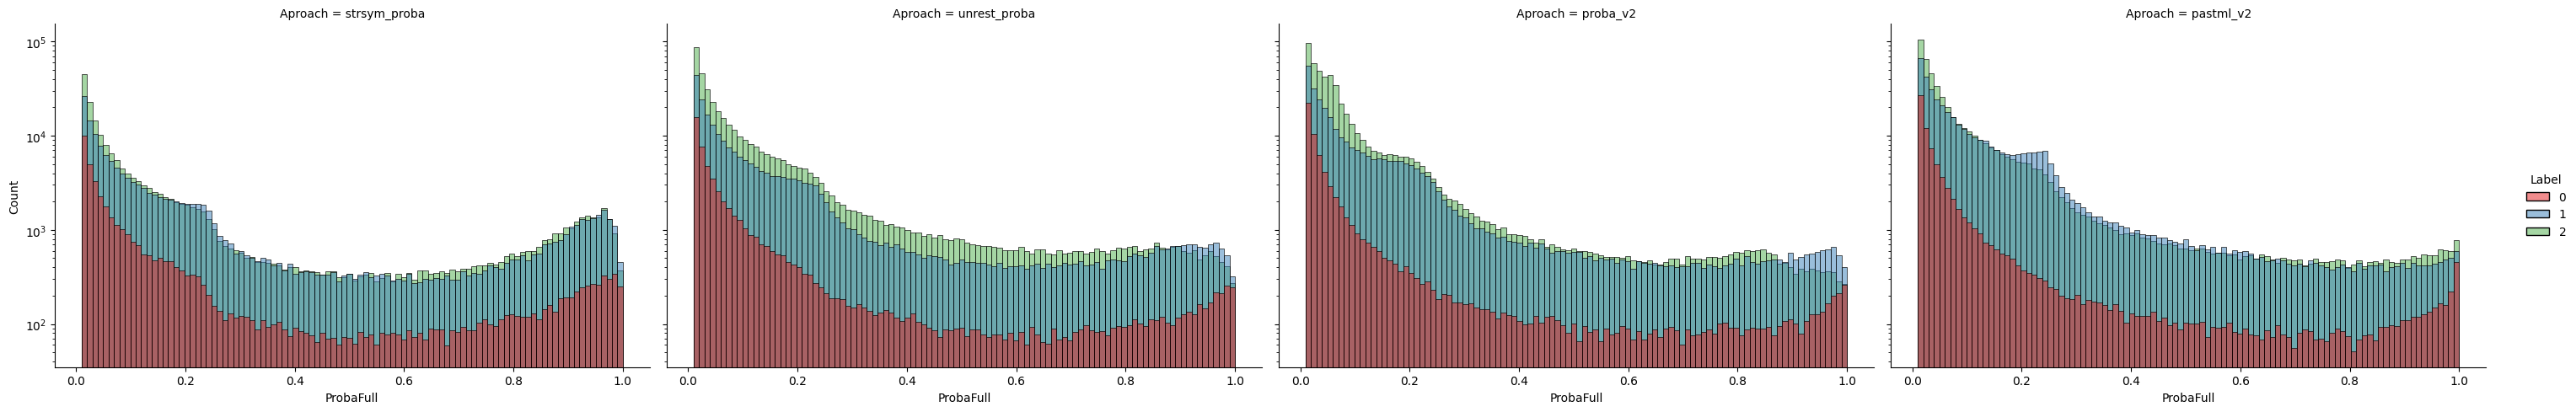

In [47]:
sns.displot(
    data=mut_nd1[(mut_nd1.Label >= 0) & (~mut_nd1.Aproach.str.contains("simple")) & (mut_nd1.ProbaFull > 0.01)], 
    x="ProbaFull", hue="Label", col="Aproach", 
    log_scale=[False, True], bins=100, palette="Set1", aspect=1.5,
);

**Number of mutations in tree edges**

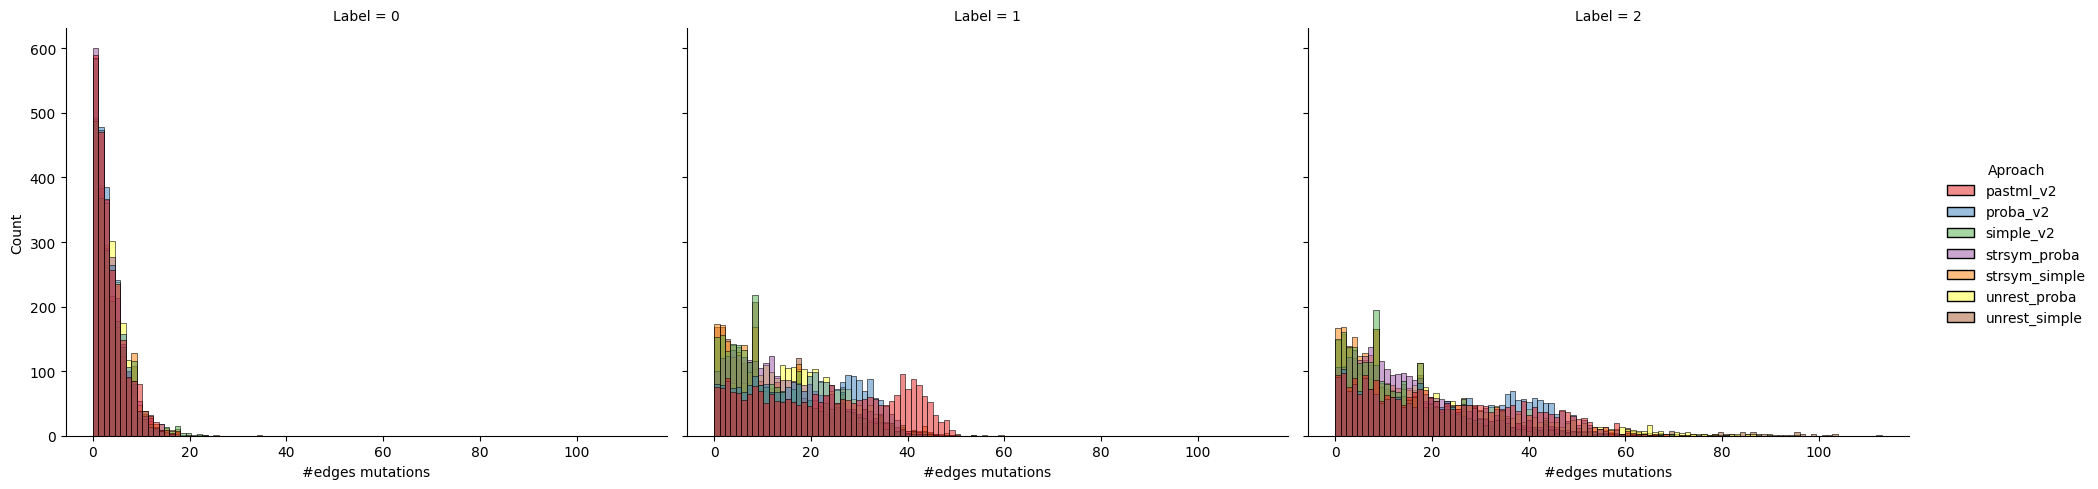

In [50]:
sns.displot(
    data=mut_nd1[mut_nd1.Label >= 0].groupby(["Aproach", "Label", "AltNode"]).ProbaFull.sum().reset_index(), 
    x="ProbaFull", col="Label", hue="Aproach", aspect=1.3, palette="Set1", bins=100,
).set_axis_labels("#edges mutations");
plt.show()

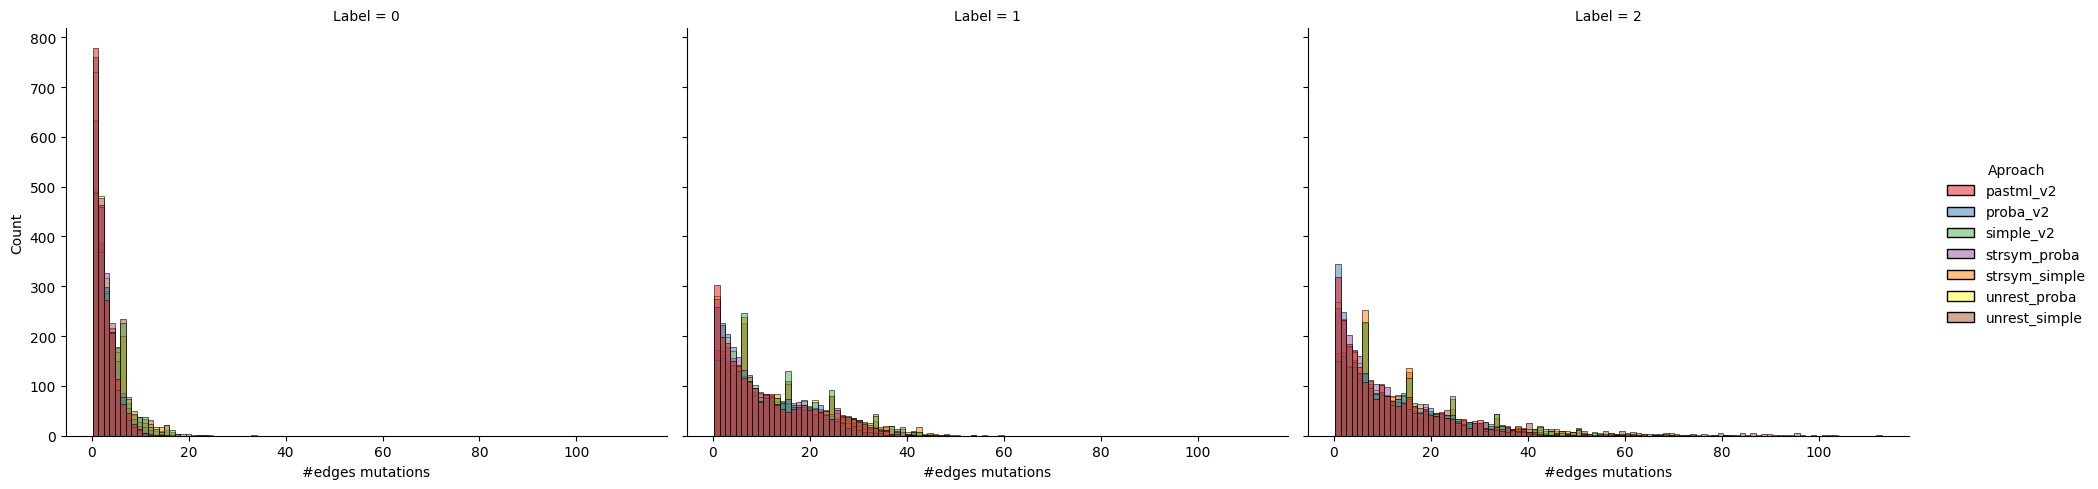

In [51]:
# after filtration (P > 0.3)
sns.displot(
    data=mut_nd1[(mut_nd1.Label >= 0) & (mut_nd1.ProbaFull > 0.3)].groupby(["Aproach", "Label", "AltNode"]).ProbaFull.sum().reset_index(), 
    x="ProbaFull", col="Label", hue="Aproach", aspect=1.3, palette="Set1", facet_kws=dict(sharex=False), bins=100,
).set_axis_labels("#edges mutations");
plt.show()

## Categorizing mutations

In [97]:
def __calc_tree_mutspec(mut, freqs, lbl="syn", pmin=0.0, pmax=1.0, collapse=False):
    """
    calculate tree mutspec from history files
    
    return mutspec of each edge in one table

    same output as calc_tree_mutspec2
    """
    # sample mutations
    mut = mut[mut.ProbaFull.between(pmin, pmax)]
    
    lbl_id = lbl2lbl_id(lbl)
    
    mutspec = []
    for (ref_node, alt_node), cur_mut in mut.groupby(["RefNode", "AltNode"]):
        # sample freqs
        _cur_freq_df = freqs[(freqs.Node == ref_node) & (freqs.Label == lbl)]
        cur_freq = _cur_freq_df[possible_sbs192].sum(axis=0).to_dict()

        # calculate mutspec
        ms192 = calculate_mutspec(cur_mut[cur_mut.Label >= lbl_id], cur_freq, use_context=True, use_proba=True)  # !!!!!!! FUCK
        ms192["RefNode"] = ref_node
        ms192["AltNode"] = alt_node
        ms192["Label"] = lbl
        mutspec.append(ms192)
    mutspec_df = pd.concat(mutspec)
    if collapse:
        mutspec_df = mutspec_df.groupby(["RefNode", "AltNode", "Label"]).apply(collapse_mutspec).reset_index()
    mutspec_df["MutBase"] = mutspec_df.Mut.str.slice(2, 5)
    mutspec_df["Context"] = mutspec_df.Mut.str.get(0) + mutspec_df.Mut.str.get(2) + mutspec_df.Mut.str.get(-1)
    return mutspec_df

In [6]:
def calc_tree_mutspec2(mut, freqs, lbl="syn", pmin=0.0, pmax=1.0, collapse=False):
    mut = mut[
            (mut.Label >= lbl2lbl_id(lbl)) & 
            (mut.ProbaFull.between(pmin, pmax))
        ].groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack()
    
    assert len(mut) > 0

    for sbs192 in set(possible_sbs192).difference(mut.columns):
        mut[sbs192] = 0.0
            
    mut = mut[possible_sbs192]
    freqs = freqs[freqs.Label == lbl]
    edges_df = mut.index.to_frame(False)

    freqs = edges_df.merge(freqs, left_on="RefNode", right_on="Node")\
        .set_index(["RefNode", "AltNode"])[possible_sbs192]
        
    assert (mut.columns == freqs.columns).all()
    assert (mut.index == freqs.index).all()

    spectra = (mut / freqs).fillna(0.)
    spectra = (spectra.T / spectra.T.sum(axis=0)).T

    return spectra


In [7]:
# space = [0.00, 0.05, 0.30, .50, 0.80, 1.00]
space = [0.00, 0.30, 1.00]

### SYN (phylo-like adjusting)

In [8]:
lbl = "syn"

ms_cat_cytb = []
for apr in mut_cytb.Aproach.unique():
    if "simple" in apr:
        continue
    for p1, p2 in zip(space[:-1], space[1:]):
        ms = calc_tree_mutspec2(
            mut_cytb[mut_cytb.Aproach == apr], 
            freqs_cytb[freqs_cytb.Aproach == apr], 
            lbl, p1, p2)
        ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
        ms["Aproach"] = apr
        ms_cat_cytb.append(ms)

ms_cat_cytb_df = pd.concat(ms_cat_cytb)
ms_cat_cytb_df = ms_cat_cytb_df.reset_index().melt(["Aproach", "RefNode", "AltNode", "Cat"], possible_sbs192, value_name="MutSpec")

ms_cat_nd1 = []
for apr in mut_nd1.Aproach.unique():
    if "simple" in apr:
        continue
    for p1, p2 in zip(space[:-1], space[1:]):
        ms = calc_tree_mutspec2(
            mut_nd1[mut_nd1.Aproach == apr], 
            freqs_nd1[freqs_nd1.Aproach == apr], 
            lbl, p1, p2)
        ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
        ms["Aproach"] = apr
        ms_cat_nd1.append(ms)

ms_cat_nd1_df = pd.concat(ms_cat_nd1)
ms_cat_nd1_df = ms_cat_nd1_df.reset_index().melt(["Aproach", "RefNode", "AltNode", "Cat"], possible_sbs192, value_name="MutSpec")

In [10]:
for apr in ms_cat_cytb_df.Aproach.unique():
    plt.figure(figsize=(50, 10))
    sns.barplot(
        x="Mut", y="MutSpec", hue="Cat", data=ms_cat_cytb_df[ms_cat_cytb_df.Aproach == apr], 
        errwidth=1, order=ordered_sbs192_kp, palette="Blues",
    )
    plt.title(f"{apr} {lbl}")
    plt.xticks(rotation=90)
    plt.savefig(f"../figures/approaches/mammals_cytb_{apr}_{lbl}_reduced_cats.svg", bbox_inches="tight")
    plt.savefig(f"../figures/approaches/mammals_cytb_{apr}_{lbl}_reduced_cats.pdf", bbox_inches="tight")
    plt.close()


for apr in ms_cat_nd1_df.Aproach.unique():
    plt.figure(figsize=(50, 10))
    sns.barplot(
        x="Mut", y="MutSpec", hue="Cat", data=ms_cat_nd1_df[ms_cat_nd1_df.Aproach == apr], errwidth=1, order=ordered_sbs192_kp, palette="Blues",
    )
    plt.title(f"{apr} {lbl}")
    plt.xticks(rotation=90)
    plt.savefig(f"../figures/approaches/mammals_nd1_{apr}_{lbl}_reduced_cats.svg", bbox_inches="tight")
    plt.savefig(f"../figures/approaches/mammals_nd1_{apr}_{lbl}_reduced_cats.pdf", bbox_inches="tight")
    plt.close()

### SYN (COSMIC-like adjusting)

In [11]:
lbl = "syn_c"

ms_cat_cytb = []
for apr in mut_cytb.Aproach.unique():
    if "simple" in apr:
        continue
    for p1, p2 in zip(space[:-1], space[1:]):
        ms = calc_tree_mutspec2(
            mut_cytb[mut_cytb.Aproach == apr], 
            freqs_cytb[freqs_cytb.Aproach == apr], 
            lbl, p1, p2)
        ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
        ms["Aproach"] = apr
        ms_cat_cytb.append(ms)

ms_cat_cytb_df = pd.concat(ms_cat_cytb)
ms_cat_cytb_df = ms_cat_cytb_df.reset_index().melt(["Aproach", "RefNode", "AltNode", "Cat"], possible_sbs192, value_name="MutSpec")

ms_cat_nd1 = []
for apr in mut_nd1.Aproach.unique():
    if "simple" in apr:
        continue
    for p1, p2 in zip(space[:-1], space[1:]):
        ms = calc_tree_mutspec2(
            mut_nd1[mut_nd1.Aproach == apr], 
            freqs_nd1[freqs_nd1.Aproach == apr], 
            lbl, p1, p2)
        ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
        ms["Aproach"] = apr
        ms_cat_nd1.append(ms)

ms_cat_nd1_df = pd.concat(ms_cat_nd1)
ms_cat_nd1_df = ms_cat_nd1_df.reset_index().melt(["Aproach", "RefNode", "AltNode", "Cat"], possible_sbs192, value_name="MutSpec")

In [12]:
for apr in ms_cat_cytb_df.Aproach.unique():
    plt.figure(figsize=(50, 10))
    sns.barplot(
        x="Mut", y="MutSpec", hue="Cat", data=ms_cat_cytb_df[ms_cat_cytb_df.Aproach == apr], 
        errwidth=1, order=ordered_sbs192_kp, palette="Blues",
    )
    plt.title(f"{apr} {lbl}")
    plt.xticks(rotation=90)
    plt.savefig(f"../figures/approaches/mammals_cytb_{apr}_{lbl}_reduced_cats.svg", bbox_inches="tight")
    plt.savefig(f"../figures/approaches/mammals_cytb_{apr}_{lbl}_reduced_cats.pdf", bbox_inches="tight")
    plt.close()


for apr in ms_cat_nd1_df.Aproach.unique():
    plt.figure(figsize=(50, 10))
    sns.barplot(
        x="Mut", y="MutSpec", hue="Cat", data=ms_cat_nd1_df[ms_cat_nd1_df.Aproach == apr], errwidth=1, order=ordered_sbs192_kp, palette="Blues",
    )
    plt.title(f"{apr} {lbl}")
    plt.xticks(rotation=90)
    plt.savefig(f"../figures/approaches/mammals_nd1_{apr}_{lbl}_reduced_cats.svg", bbox_inches="tight")
    plt.savefig(f"../figures/approaches/mammals_nd1_{apr}_{lbl}_reduced_cats.pdf", bbox_inches="tight")
    plt.close()